# Compare V gene and J gene use in in-house data versus Adaptive data

We have already run `vgene_usage_stats.ipynb` for both datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from malid import config, io, helpers
from malid.datamodels import (
    healthy_label,
    GeneLocus,
    TargetObsColumnEnum,
    CrossValidationSplitStrategy,
    DataSource,
)
import gc
import joblib
from kdict import kdict
import itertools
import genetools
from pathlib import Path
from slugify import slugify
import scanpy as sc
import anndata

In [2]:
def get_dirs(
    gene_locus: GeneLocus, cross_validation_split_strategy: CrossValidationSplitStrategy
):
    paths = config.make_paths(
        embedder=config.embedder,
        cross_validation_split_strategy=cross_validation_split_strategy,
        dataset_version=config.dataset_version,
    )
    output_dir = (
        paths.model_interpretations_for_selected_cross_validation_strategy_output_dir
        / gene_locus.name
    )
    highres_output_dir = (
        paths.high_res_outputs_dir_for_cross_validation_strategy
        / "model_interpretations"
        / gene_locus.name
    )

    # Create directories - though these directories should already have been created by sequence model interpretations notebooks
    output_dir.mkdir(parents=True, exist_ok=True)
    highres_output_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, highres_output_dir

In [3]:
# reimport (can resume here)
def import_v_gene_counts(
    gene_locus: GeneLocus, cross_validation_split_strategy: CrossValidationSplitStrategy
):
    output_dir, highres_output_dir = get_dirs(
        gene_locus, cross_validation_split_strategy
    )

    specimen_v_gene_counts_df = pd.read_csv(
        highres_output_dir / "v_gene_counts_by_specimen.tsv.gz", sep="\t"
    )

    # subselect to test folds only (which also excludes global fold -1), and set index
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df[
        specimen_v_gene_counts_df["fold_label"] == "test"
    ]

    # confirm only one entry per specimen now
    assert not specimen_v_gene_counts_df_test_only["specimen_label"].duplicated().any()
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.set_index(
        "specimen_label"
    ).drop(["fold_id", "fold_label"], axis=1)

    # fill na
    specimen_v_gene_counts_df_test_only = specimen_v_gene_counts_df_test_only.fillna(0)

    v_gene_cols = specimen_v_gene_counts_df_test_only.columns
    v_gene_cols = v_gene_cols[~v_gene_cols.isin(["disease"])]

    # get filtered subset of v_gene_cols, produced previously
    v_gene_cols_filtered = pd.read_csv(output_dir / "meaningful_v_genes.txt")[
        "v_gene"
    ].values
    assert all(vgene in v_gene_cols for vgene in v_gene_cols_filtered)  # sanity check

    return specimen_v_gene_counts_df_test_only, v_gene_cols, v_gene_cols_filtered

In [4]:
extra_specimen_metadata = helpers.get_all_specimen_info()
extra_specimen_metadata

,participant_label,specimen_label,disease,specimen_time_point,participant_description,data_source,study_name,available_gene_loci,disease_subtype,age,...,symptoms_cmv,symptoms_healthy_in_resequencing_experiment,specimen_time_point_days,survived_filters,is_selected_for_cv_strategy,in_training_set,past_exposure,disease.separate_past_exposures,disease.rollup,test_fold_id
0,BFI-0000234,M124-S014,Healthy/Background,NaN,Location: USA,DataSource.in_house,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,27.0,...,NaN,NaN,NaN,True,True,True,False,Healthy/Background,Healthy/Background,1.0
1,BFI-0000234,M132-S014,Healthy/Background,NaN,Location: USA,DataSource.in_house,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,27.0,...,NaN,NaN,NaN,False,True,False,False,Healthy/Background,Healthy/Background,NaN
2,BFI-0002850,M124-S042,Healthy/Background,NaN,Location: USA,DataSource.in_house,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,26.0,...,NaN,NaN,NaN,True,True,True,False,Healthy/Background,Healthy/Background,0.0
3,BFI-0002850,M132-S040,Healthy/Background,NaN,Location: USA,DataSource.in_house,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,26.0,...,NaN,NaN,NaN,False,True,False,False,Healthy/Background,Healthy/Background,NaN
4,BFI-0002851,M124-S041,Healthy/Background,NaN,Location: USA,DataSource.in_house,HIV,"(((GeneLocus.BCR)), ((GeneLocus.TCR)))",Healthy/Background - HIV Negative,27.0,...,NaN,NaN,NaN,True,True,True,False,Healthy/Background,Healthy/Background,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,ramesh-2015-ci_378,ramesh-2015-ci_378,CVID,NaN,NaN,DataSource.adaptive,ramesh-2015-ci,(((GeneLocus.TCR))),CVID,NaN,...,NaN,NaN,NaN,True,False,False,False,CVID,CVID,NaN
2541,ramesh-2015-ci_386,ramesh-2015-ci_386,CVID,NaN,NaN,DataSource.adaptive,ramesh-2015-ci,(((GeneLocus.TCR))),CVID,NaN,...,NaN,NaN,NaN,True,False,False,False,CVID,CVID,NaN
2542,ramesh-2015-ci_400,ramesh-2015-ci_400,CVID,NaN,NaN,DataSource.adaptive,ramesh-2015-ci,(((GeneLocus.TCR))),CVID,NaN,...,NaN,NaN,NaN,True,False,False,False,CVID,CVID,NaN
2543,ramesh-2015-ci_441,ramesh-2015-ci_441,CVID,NaN,NaN,DataSource.adaptive,ramesh-2015-ci,(((GeneLocus.TCR))),CVID,NaN,...,NaN,NaN,NaN,True,False,False,False,CVID,CVID,NaN


In [5]:
(
    specimen_v_gene_counts_df_test_only,
    v_gene_cols,
    v_gene_cols_filtered,
) = import_v_gene_counts(
    gene_locus=GeneLocus.TCR,
    cross_validation_split_strategy=CrossValidationSplitStrategy.in_house_peak_disease_timepoints,
)

# Get V gene usage proportions per specimen
v_gene_usage_proportions_by_specimen = pd.concat(
    [
        genetools.stats.normalize_rows(
            specimen_v_gene_counts_df_test_only[v_gene_cols]
        ),
        specimen_v_gene_counts_df_test_only["disease"],
    ],
    axis=1,
)

v_gene_usage_proportions_by_specimen_annot = genetools.helpers.merge_into_left(
    v_gene_usage_proportions_by_specimen[v_gene_cols],
    extra_specimen_metadata.set_index("specimen_label"),
)


# drop specimens with group N/A
v_gene_usage_proportions_by_specimen_annot = (
    v_gene_usage_proportions_by_specimen_annot.dropna(subset=["study_name"])
)

v_gene_usage_proportions_by_specimen_annot_melt = pd.melt(
    v_gene_usage_proportions_by_specimen_annot,
    id_vars=["disease", "study_name"],
    value_vars=v_gene_cols,
    var_name="V gene",
    value_name="Proportion",
)
v_gene_usage_proportions_by_specimen_annot_melt

,disease,study_name,V gene,Proportion
0,HIV,HIV,TRBV20-1,0.148753
1,HIV,HIV,TRBV20-1,0.110762
2,HIV,HIV,TRBV20-1,0.108428
3,HIV,HIV,TRBV20-1,0.128473
4,HIV,HIV,TRBV20-1,0.123847
...,...,...,...,...
30795,Healthy/Background,Healthy-StanfordBloodCenter,TRBV17,0.000000
30796,Healthy/Background,Healthy-StanfordBloodCenter,TRBV17,0.000000
30797,Healthy/Background,Healthy-StanfordBloodCenter,TRBV17,0.000000
30798,Healthy/Background,Healthy-StanfordBloodCenter,TRBV17,0.000000


In [6]:
(
    specimen_v_gene_counts_df_test_only_adaptive,
    v_gene_cols_adaptive,
    v_gene_cols_filtered_adaptive,
) = import_v_gene_counts(
    gene_locus=GeneLocus.TCR,
    cross_validation_split_strategy=CrossValidationSplitStrategy.adaptive_peak_disease_timepoints,
)

# Get V gene usage proportions per specimen
v_gene_usage_proportions_by_specimen_adaptive = pd.concat(
    [
        genetools.stats.normalize_rows(
            specimen_v_gene_counts_df_test_only_adaptive[v_gene_cols_adaptive]
        ),
        specimen_v_gene_counts_df_test_only_adaptive["disease"],
    ],
    axis=1,
)

v_gene_usage_proportions_by_specimen_annot_adaptive = genetools.helpers.merge_into_left(
    v_gene_usage_proportions_by_specimen_adaptive[v_gene_cols_adaptive],
    extra_specimen_metadata.set_index("specimen_label"),
)


# drop specimens with group N/A
v_gene_usage_proportions_by_specimen_annot_adaptive = (
    v_gene_usage_proportions_by_specimen_annot_adaptive.dropna(subset=["study_name"])
)

v_gene_usage_proportions_by_specimen_annot_melt_adaptive = pd.melt(
    v_gene_usage_proportions_by_specimen_annot_adaptive,
    id_vars=["disease", "study_name"],
    value_vars=v_gene_cols_adaptive,
    var_name="V gene",
    value_name="Proportion",
)
v_gene_usage_proportions_by_specimen_annot_melt_adaptive

,disease,study_name,V gene,Proportion
0,Healthy/Background,TCRBv4-control,TRBV20-1,0.069645
1,Healthy/Background,TCRBv4-control,TRBV20-1,0.060843
2,Healthy/Background,TCRBv4-control,TRBV20-1,0.072642
3,Healthy/Background,TCRBv4-control,TRBV20-1,0.082730
4,Healthy/Background,TCRBv4-control,TRBV20-1,0.075243
...,...,...,...,...
84625,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84626,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84627,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84628,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000


In [7]:
v_gene_usage_proportions_by_specimen_annot_melt_combined = pd.concat(
    [
        v_gene_usage_proportions_by_specimen_annot_melt,
        v_gene_usage_proportions_by_specimen_annot_melt_adaptive,
    ],
    axis=0,
)
v_gene_usage_proportions_by_specimen_annot_melt_combined

,disease,study_name,V gene,Proportion
0,HIV,HIV,TRBV20-1,0.148753
1,HIV,HIV,TRBV20-1,0.110762
2,HIV,HIV,TRBV20-1,0.108428
3,HIV,HIV,TRBV20-1,0.128473
4,HIV,HIV,TRBV20-1,0.123847
...,...,...,...,...
84625,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84626,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84627,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000
84628,HIV,towlerton-2022-hiv,TRBV26/OR9-2,0.000000


In [8]:
group_color_palette = {
    group: color
    for group, color in zip(
        v_gene_usage_proportions_by_specimen_annot_melt_combined["study_name"].unique(),
        sc.plotting.palettes.default_102,
    )
}


def plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined: pd.DataFrame,
    disease: str,
    filtered=False,
):
    height = 7 if filtered else 13
    selected_v_gene_order = pd.Series(v_gene_cols_filtered if filtered else v_gene_cols)

    selected_v_gene_order = pd.Series(
        sorted(
            v_gene_usage_proportions_by_specimen_annot_melt_combined["V gene"].unique()
        )
    )

    v_gene_usage_proportions_by_specimen_annot_melt_this_disease = (
        v_gene_usage_proportions_by_specimen_annot_melt_combined[
            v_gene_usage_proportions_by_specimen_annot_melt_combined["disease"]
            == disease
        ]
    )
    # Sort for consistent group order
    groups_this_disease = sorted(
        v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
            "study_name"
        ].unique()
    )
    if len(groups_this_disease) == 0:
        print(f"No study_name group info for {disease} - skipping")
        return None

    # Divide the disease plot into subplots by group
    fig, axarr = plt.subplots(
        nrows=1,
        ncols=len(groups_this_disease),
        figsize=(3 * len(groups_this_disease), height),
        sharex=True,  # Make xlims consistent for better readability
        sharey=False,  # Repeat the V gene in each axis for better readability
    )
    for (group, ax) in zip(groups_this_disease, axarr):
        data = v_gene_usage_proportions_by_specimen_annot_melt_this_disease[
            v_gene_usage_proportions_by_specimen_annot_melt_this_disease["study_name"]
            == group
        ]
        sns.barplot(
            # Switch to friendly V gene names
            data=data.assign(
                **{"V gene": data["V gene"].replace(helpers.v_gene_friendly_names)}
            ),
            x="Proportion",
            y="V gene",
            # reference V gene order, possibly filtered down
            order=sorted(selected_v_gene_order.replace(helpers.v_gene_friendly_names)),
            ax=ax,
            color=group_color_palette[group],
            # Compute 95% confidence intervals around a sample mean by bootstrapping:
            # sampling distribution of mean generated by repeated sampling and recording mean each time.
            # the standard error is basically the standard deviation of many sample means
            # we plot mean +/- 1.96*standard error. gives you average value +/- X at the 95% confidence level.
            errorbar=("ci", 95),
            # errorbar="sd", # instead draw the standard deviation of the observations, instead of bootstrapping to get 95% confidence intervals
            # capsize=.025
        )

        ax.set_title(f"{group}", fontweight="bold")
        ax.set_xlabel("Proportion of specimen\n(mean +/- 95% confidence interval)")
        ax.set_ylabel(None)
        sns.despine(ax=ax)

    axarr[0].set_ylabel("V gene")
    fig.suptitle(disease, fontsize="x-large", fontweight="bold")
    plt.tight_layout()
    return fig

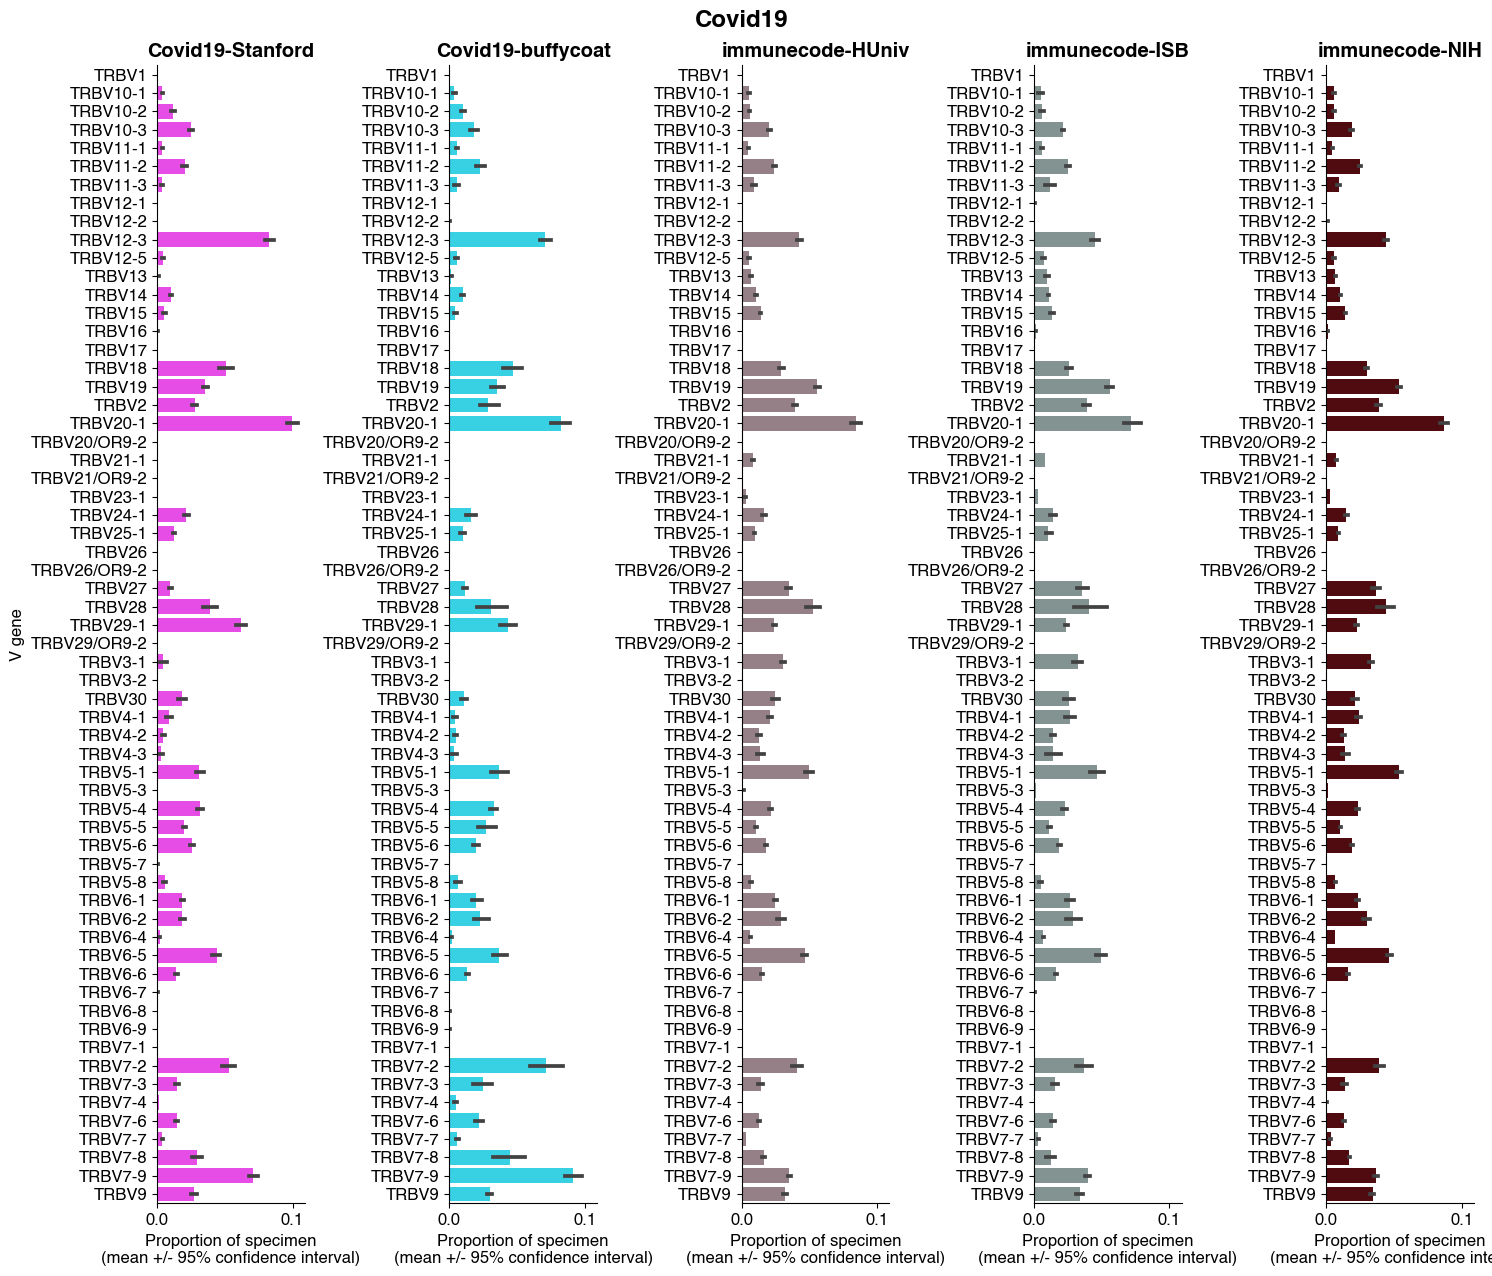

In [9]:
# Plot for all V genes
fig = plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined=v_gene_usage_proportions_by_specimen_annot_melt_combined,
    disease="Covid19",
    filtered=False,
)

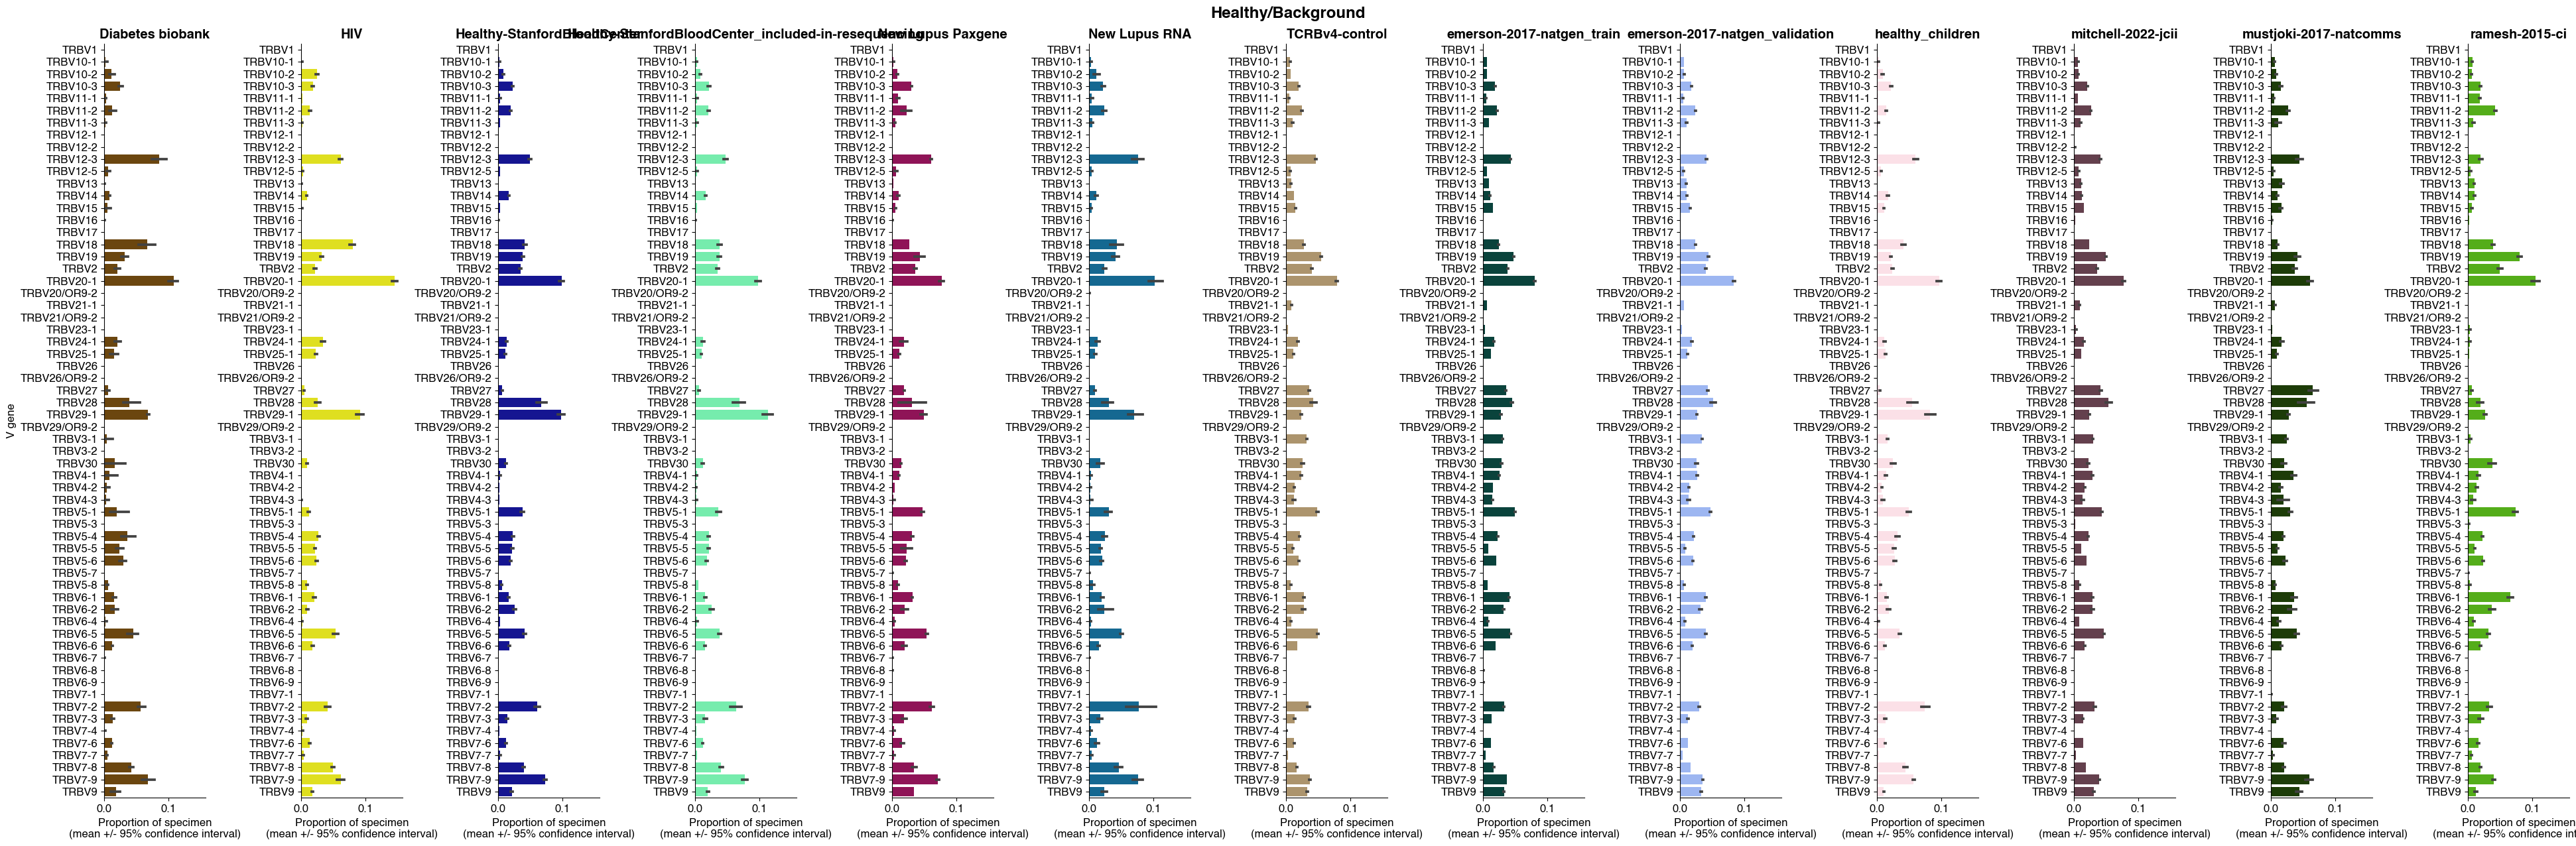

In [10]:
# Plot for all V genes
fig = plot_per_disease(
    v_gene_usage_proportions_by_specimen_annot_melt_combined=v_gene_usage_proportions_by_specimen_annot_melt_combined,
    disease="Healthy/Background",
    filtered=False,
)

# Embed on UMAP and see where it lands?

In [11]:
ec_data_c = pd.concat(
    [
        v_gene_usage_proportions_by_specimen_annot_adaptive[v_gene_cols_adaptive],
        v_gene_usage_proportions_by_specimen_annot[v_gene_cols],
    ],
    axis=0,
)
ec_data_c

,TRBV20-1,TRBV19,TRBV5-1,TRBV28,TRBV6-5,TRBV27,TRBV12-3,TRBV9,TRBV7-9,TRBV7-2,...,TRBV5-7,TRBV6-9,TRBV7-1,TRBV17,TRBV26,TRBV20/OR9-2,TRBV21/OR9-2,TRBV3-2,TRBV29/OR9-2,TRBV26/OR9-2
specimen_label,,,,,,,,,,,,,,,,,,,,,
TCRBv4-control_Subject_100,0.069645,0.053293,0.052051,0.020800,0.056077,0.041651,0.048982,0.033798,0.044136,0.032033,...,0.000249,0.000323,0.000012,0.000124,0.000000,0.000000,0.0,0.0,0.0,0.0
TCRBv4-control_Subject_103,0.060843,0.058925,0.056636,0.047862,0.055658,0.040966,0.039489,0.039372,0.040017,0.028602,...,0.000196,0.000137,0.000000,0.000049,0.000000,0.000000,0.0,0.0,0.0,0.0
TCRBv4-control_Subject_106,0.072642,0.059516,0.052164,0.017712,0.055173,0.040590,0.053770,0.031741,0.036098,0.019398,...,0.000162,0.000135,0.000000,0.000027,0.000013,0.000000,0.0,0.0,0.0,0.0
TCRBv4-control_Subject_13,0.082730,0.052604,0.027353,0.084129,0.043884,0.038347,0.037161,0.028253,0.037283,0.033144,...,0.000188,0.000245,0.000016,0.000025,0.000000,0.000000,0.0,0.0,0.0,0.0
TCRBv4-control_Subject_155,0.075243,0.047405,0.054927,0.061541,0.049596,0.043772,0.037276,0.038441,0.034275,0.030366,...,0.000178,0.000257,0.000020,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M64-094,0.106241,0.027117,0.029346,0.068351,0.032318,0.010401,0.046805,0.020802,0.070208,0.054235,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000743,NaN,0.0,0.0,NaN
M64-095,0.069213,0.033711,0.063513,0.061721,0.027441,0.005944,0.044866,0.019461,0.081752,0.081997,...,0.000407,0.000081,0.000000,0.000000,0.000000,0.000326,NaN,0.0,0.0,NaN
M64-099,0.084934,0.034455,0.055136,0.062023,0.048885,0.004639,0.036527,0.020716,0.060961,0.052604,...,0.000301,0.000301,0.000000,0.000000,0.000000,0.000071,NaN,0.0,0.0,NaN


In [12]:
ec_obs_c = pd.concat(
    [
        v_gene_usage_proportions_by_specimen_annot_adaptive[
            ["study_name", "disease", "data_source"]
        ],
        v_gene_usage_proportions_by_specimen_annot[
            ["study_name", "disease", "data_source"]
        ],
    ],
    axis=0,
)
ec_obs_c

,study_name,disease,data_source
specimen_label,,,
TCRBv4-control_Subject_100,TCRBv4-control,Healthy/Background,DataSource.adaptive
TCRBv4-control_Subject_103,TCRBv4-control,Healthy/Background,DataSource.adaptive
TCRBv4-control_Subject_106,TCRBv4-control,Healthy/Background,DataSource.adaptive
TCRBv4-control_Subject_13,TCRBv4-control,Healthy/Background,DataSource.adaptive
TCRBv4-control_Subject_155,TCRBv4-control,Healthy/Background,DataSource.adaptive
...,...,...,...
M64-094,Healthy-StanfordBloodCenter,Healthy/Background,DataSource.in_house
M64-095,Healthy-StanfordBloodCenter,Healthy/Background,DataSource.in_house
M64-099,Healthy-StanfordBloodCenter,Healthy/Background,DataSource.in_house


In [13]:
ec_data_c.isna().any()

TRBV20-1        False
TRBV19          False
TRBV5-1         False
TRBV28          False
TRBV6-5         False
                ...  
TRBV20/OR9-2    False
TRBV21/OR9-2     True
TRBV3-2         False
TRBV29/OR9-2    False
TRBV26/OR9-2     True
Length: 62, dtype: bool

In [14]:
ec_data_c = ec_data_c.dropna(axis=1)

In [15]:
meaningful_v_genes = list(v_gene_cols_filtered)
meaningful_v_genes

['TRBV14',
 'TRBV4-1',
 'TRBV7-6',
 'TRBV6-6',
 'TRBV11-2',
 'TRBV6-2',
 'TRBV6-1',
 'TRBV10-3',
 'TRBV10-2',
 'TRBV25-1',
 'TRBV5-5',
 'TRBV9',
 'TRBV2',
 'TRBV30',
 'TRBV24-1',
 'TRBV5-6',
 'TRBV5-1',
 'TRBV19',
 'TRBV5-4',
 'TRBV6-5',
 'TRBV28',
 'TRBV7-8',
 'TRBV7-2',
 'TRBV7-9',
 'TRBV12-3',
 'TRBV18',
 'TRBV29-1',
 'TRBV20-1']

In [16]:
adata_subset = anndata.AnnData(
    ec_data_c[[v for v in meaningful_v_genes if v in ec_data_c.columns]], obs=ec_obs_c
)
adata_subset

{"message": "/tmp/ipykernel_2598399/2016513.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.\n  adata_subset = anndata.AnnData(\n", "time": "2024-04-01T16:20:41.284106"}


AnnData object with n_obs × n_vars = 1915 × 28
    obs: 'study_name', 'disease', 'data_source'

In [17]:
adata_subset.shape

(1915, 28)

In [18]:
adata_subset.obs["label"] = (
    adata_subset.obs["disease"] + " - " + adata_subset.obs["study_name"]
)

In [19]:
# make a new label like Covid-19 (Mal-ID), Covid-19 (Adaptive), etc.
adata_subset.obs.drop_duplicates()

,study_name,disease,data_source,label
specimen_label,,,,
TCRBv4-control_Subject_100,TCRBv4-control,Healthy/Background,DataSource.adaptive,Healthy/Background - TCRBv4-control
emerson-2017-natgen_train_HIP00110,emerson-2017-natgen_train,Healthy/Background,DataSource.adaptive,Healthy/Background - emerson-2017-natgen_train
emerson-2017-natgen_validation_Keck0001_MC1,emerson-2017-natgen_validation,Healthy/Background,DataSource.adaptive,Healthy/Background - emerson-2017-natgen_valid...
immunecode_860011110_TCRB,immunecode-HUniv,Covid19,DataSource.adaptive,Covid19 - immunecode-HUniv
immunecode_BS-EQ-0014-T2-replacement_TCRB,immunecode-NIH,Covid19,DataSource.adaptive,Covid19 - immunecode-NIH
immunecode_INCOV073-BL-3_TCRB,immunecode-ISB,Covid19,DataSource.adaptive,Covid19 - immunecode-ISB
mitchell-2022-jcii_310104,mitchell-2022-jcii,Healthy/Background,DataSource.adaptive,Healthy/Background - mitchell-2022-jcii
mitchell-2022-jcii_DenverT1D-046,mitchell-2022-jcii,T1D,DataSource.adaptive,T1D - mitchell-2022-jcii
mustjoki-2017-natcomms_HC11,mustjoki-2017-natcomms,Healthy/Background,DataSource.adaptive,Healthy/Background - mustjoki-2017-natcomms


In [20]:
adata_subset.obs["data_source"] = adata_subset.obs["data_source"].map(
    {DataSource.adaptive: "Adaptive", DataSource.in_house: "Mal-ID"}
)
assert not adata_subset.obs["data_source"].isna().any()

In [21]:
adata_subset.obs["label2"] = (
    adata_subset.obs["disease"].astype(str) + " - " + adata_subset.obs["data_source"]
)
adata_subset.obs["label2"].value_counts()

Healthy/Background - Adaptive    1009
Healthy/Background - Mal-ID       197
T1D - Adaptive                    143
HIV - Mal-ID                       98
T1D - Mal-ID                       96
Covid19 - Adaptive                 88
Lupus - Mal-ID                     64
HIV - Adaptive                     60
Covid19 - Mal-ID                   58
Influenza - Mal-ID                 37
CVID - Adaptive                    35
RA - Adaptive                      30
Name: label2, dtype: int64

In [22]:
adata_subset.obs.drop_duplicates()

,study_name,disease,data_source,label,label2
specimen_label,,,,,
TCRBv4-control_Subject_100,TCRBv4-control,Healthy/Background,Adaptive,Healthy/Background - TCRBv4-control,Healthy/Background - Adaptive
emerson-2017-natgen_train_HIP00110,emerson-2017-natgen_train,Healthy/Background,Adaptive,Healthy/Background - emerson-2017-natgen_train,Healthy/Background - Adaptive
emerson-2017-natgen_validation_Keck0001_MC1,emerson-2017-natgen_validation,Healthy/Background,Adaptive,Healthy/Background - emerson-2017-natgen_valid...,Healthy/Background - Adaptive
immunecode_860011110_TCRB,immunecode-HUniv,Covid19,Adaptive,Covid19 - immunecode-HUniv,Covid19 - Adaptive
immunecode_BS-EQ-0014-T2-replacement_TCRB,immunecode-NIH,Covid19,Adaptive,Covid19 - immunecode-NIH,Covid19 - Adaptive
immunecode_INCOV073-BL-3_TCRB,immunecode-ISB,Covid19,Adaptive,Covid19 - immunecode-ISB,Covid19 - Adaptive
mitchell-2022-jcii_310104,mitchell-2022-jcii,Healthy/Background,Adaptive,Healthy/Background - mitchell-2022-jcii,Healthy/Background - Adaptive
mitchell-2022-jcii_DenverT1D-046,mitchell-2022-jcii,T1D,Adaptive,T1D - mitchell-2022-jcii,T1D - Adaptive
mustjoki-2017-natcomms_HC11,mustjoki-2017-natcomms,Healthy/Background,Adaptive,Healthy/Background - mustjoki-2017-natcomms,Healthy/Background - Adaptive


In [23]:
sc.pp.scale(adata_subset)

In [24]:
sc.tl.pca(adata_subset)

In [25]:
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: \u001bThe 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.\u001b\n  @numba.jit()\n", "time": "2024-04-01T16:20:41.732105"}


{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: \u001bThe 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.\u001b\n  @numba.jit()\n", "time": "2024-04-01T16:20:41.733023"}


{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: \u001bThe 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.\u001b\n  @numba.jit()\n", "time": "2024-04-01T16:20:41.733899"}


{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: \u001bThe 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.\u001b\n  @numba.jit()\n", "time": "2024-04-01T16:20:46.073453"}


2024-04-01 16:20:46.395026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2024-04-01 16:20:46.449743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-01 16:20:51.184188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{"message": "... storing 'study_name' as categorical", "time": "2024-04-01T16:21:06.547678"}


{"message": "... storing 'disease' as categorical", "time": "2024-04-01T16:21:06.549295"}


{"message": "... storing 'data_source' as categorical", "time": "2024-04-01T16:21:06.550340"}


{"message": "... storing 'label' as categorical", "time": "2024-04-01T16:21:06.551607"}


{"message": "... storing 'label2' as categorical", "time": "2024-04-01T16:21:06.552643"}


{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:06.648169"}


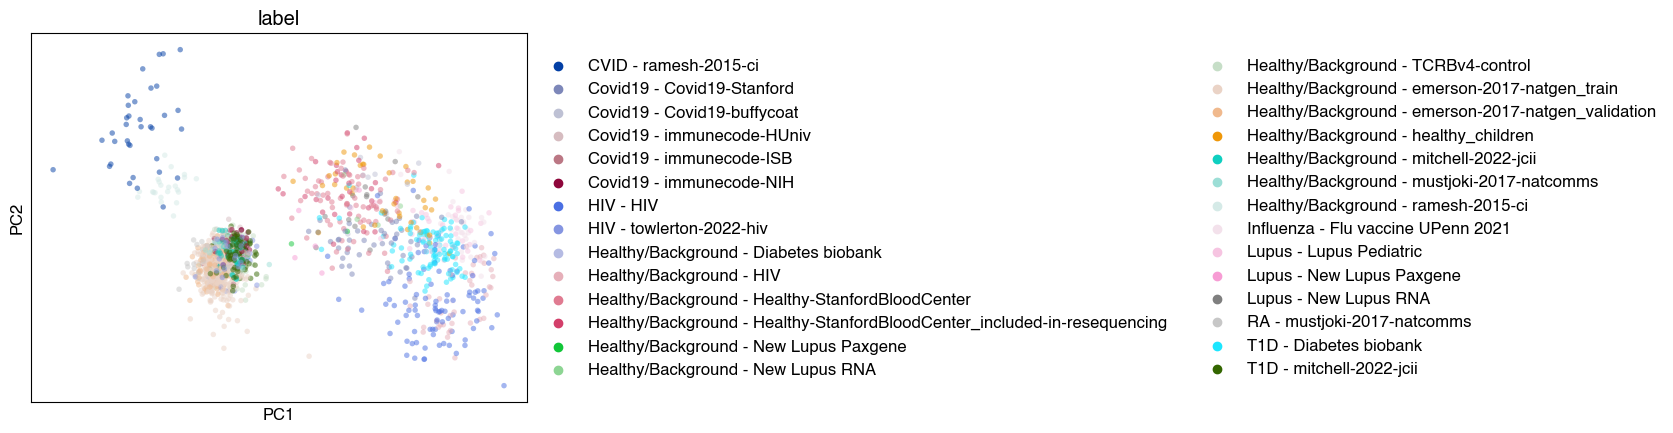

In [26]:
sc.pl.pca(adata_subset, color="label", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:07.121871"}


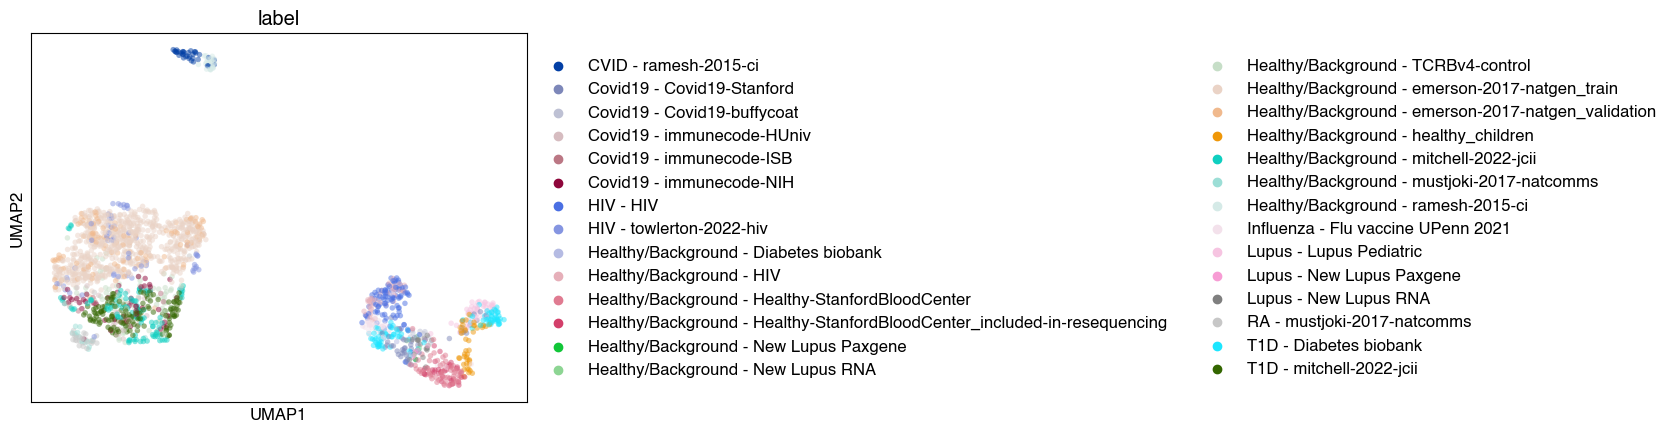

In [27]:
sc.pl.umap(adata_subset, color="label", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:07.548177"}


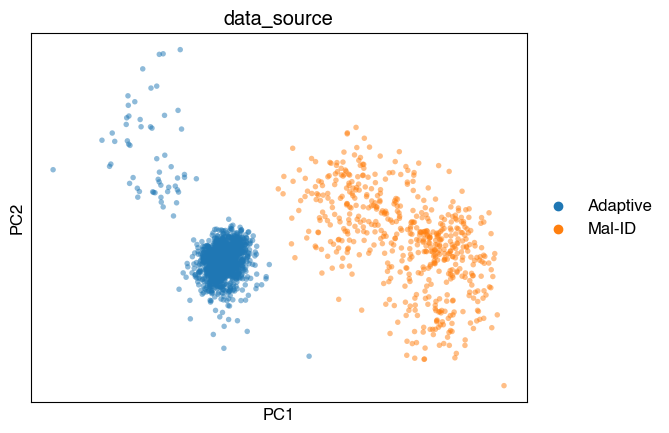

In [28]:
sc.pl.pca(adata_subset, color="data_source", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:07.638367"}


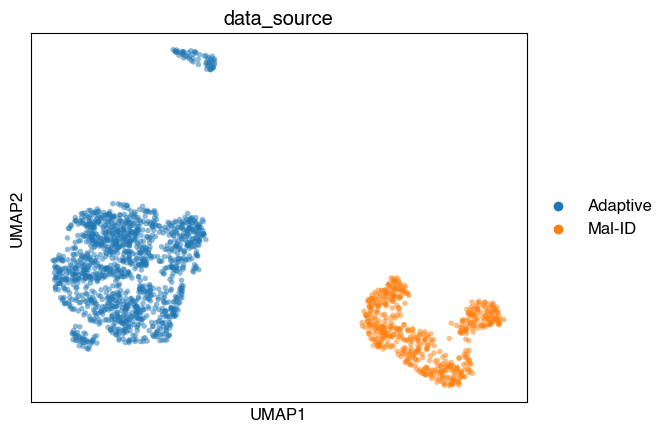

In [29]:
sc.pl.umap(adata_subset, color="data_source", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:07.729564"}


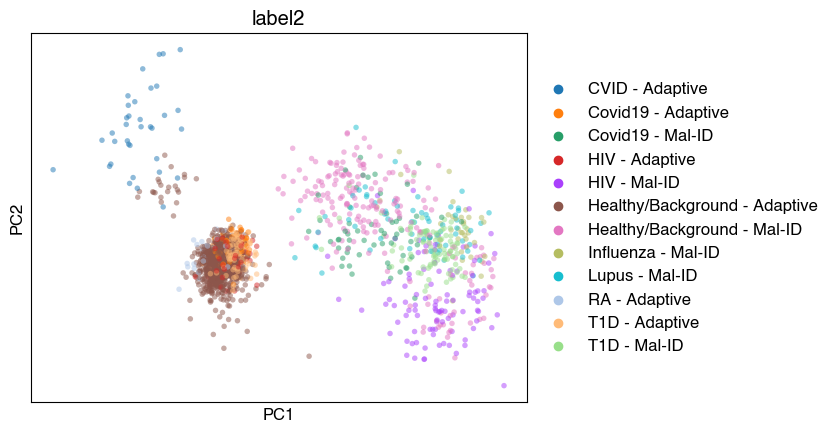

In [30]:
sc.pl.pca(adata_subset, color="label2", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:07.944649"}


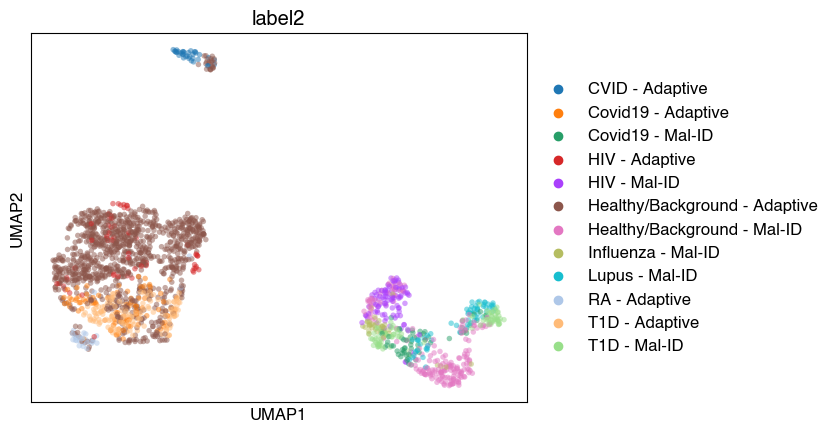

In [31]:
sc.pl.umap(adata_subset, color="label2", alpha=0.5)

{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:08.156295"}


{"message": "/users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored\n  cax = scatter(\n", "time": "2024-04-01T16:21:08.173409"}


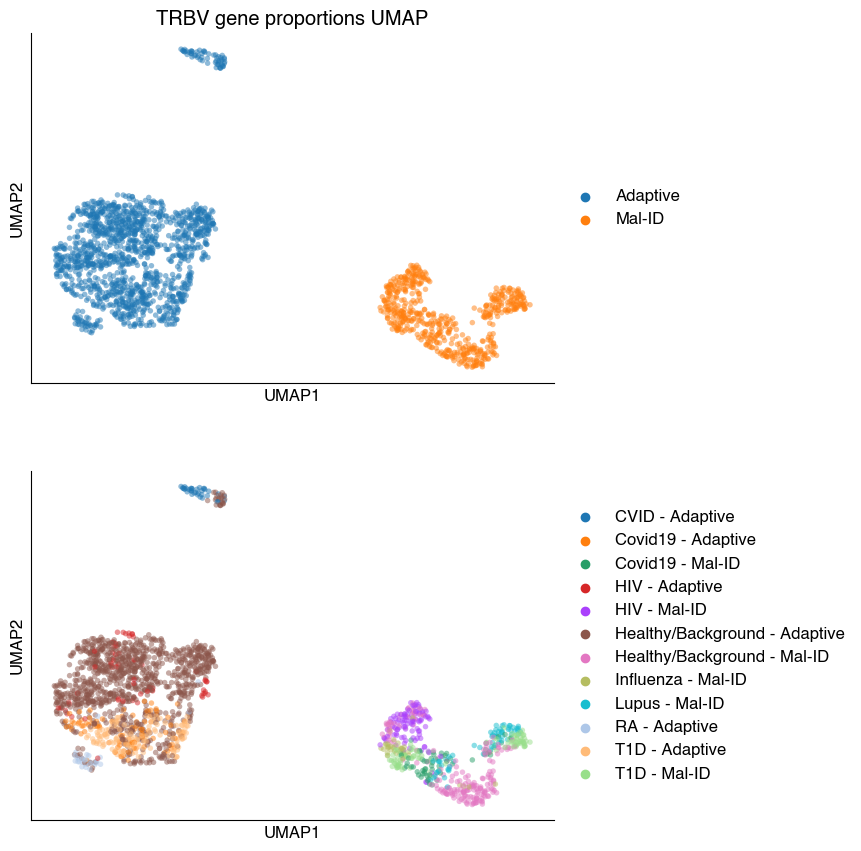

In [32]:
fig_umap = sc.pl.umap(
    adata_subset,
    color=["data_source", "label2"],
    alpha=0.5,
    return_fig=True,
    title=["TRBV gene proportions UMAP", ""],
    ncols=1,
)
sns.despine(fig=fig_umap)
genetools.plots.savefig(
    fig_umap,
    config.paths.model_interpretations_for_selected_cross_validation_strategy_output_dir
    / GeneLocus.TCR.name
    / f"v_gene_proportions_by_specimen.adaptive_vs_malid.png",
    dpi=300,
)

In [33]:
# TODO: add the other external cohorts that are more similar to ours